Copyright (C) 2022 King Saud University, Saudi Arabia
SPDX-License-Identifier: Apache-2.0

Licensed under the Apache License, Version 2.0 (the "License"); you may not use
this file except in compliance with the License. You may obtain a copy of the
License at

http://www.apache.org/licenses/LICENSE-2.0  

Unless required by applicable law or agreed to in writing, software distributed
under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR
CONDITIONS OF ANY KIND, either express or implied. See the License for the
specific language governing permissions and limitations under the License.

Author:  Hamdi Altaheri
Edit : Abdelrahman Fatouh @abdo20050

use section below to download BCI dataset


In [ ]:
# import os
# if not  os.path.exists('./BCI'):
#   !mkdir BCI
#   for i in range(9):
#     !wget -qN https://lampx.tugraz.at/~bci/database/001-2014/A0{i+1}T.mat -P ./BCI
#     !wget -qN https://lampx.tugraz.at/~bci/database/001-2014/A0{i+1}E.mat -P ./BCI

Use section below to download CSV dataset

In [ ]:
#download dataset
import os
if not os.path.exists('./CSV'):
  !wget -qN --no-check-certificate "https://drive.usercontent.google.com/download?id=1sAKu5WkaSur7-Fno9vfpVD5r4Ox_nPIs&authuser=0&confirm=t&uuid=9548f40b-5a0b-48de-a948-993ae260819d&at=APZUnTXh1GLeiaL8EZYg5NEc00Aq%3A1715712771291" -O records.zip
  !unzip -uq records.zip
  !mv ./records ./CSV

Download needed scripts to run the notebook.

In [ ]:
#add necessary files
!wget -qN https://github.com/abdo20050/EEG-ATCNet/raw/main/custom_loader.py
!wget -qN https://github.com/abdo20050/EEG-ATCNet/raw/main/preprocess.py
!wget -qN https://github.com/abdo20050/EEG-ATCNet/raw/main/models.py
!wget -qN https://github.com/abdo20050/EEG-ATCNet/raw/main/attention_models.py

In [ ]:
#That section if you use it on Google colab or similar sevices
!pip -q install "mne[hdf5]"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 14.7 MB/s eta 0:00:00


Import libraries and models

In [ ]:
#libraryies
import os
import sys
import shutil
import time
import numpy as np
import matplotlib.pyplot as plt
np.object = np.object_
np.bool = np.bool_
np.int = np.int_
import tensorflow as tf

from keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split

import models
from preprocess import get_data
from tensorflow.keras.utils import plot_model


That function is useful for plotting and displaying hte results

In [ ]:
#plot functions
def draw_learning_curves(history, sub):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy - subject: ' + str(sub))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'val'], loc='upper left')
    plt.show()
    plt.figure(2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss - subject: ' + str(sub))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'val'], loc='upper left')
    plt.show()
    plt.close()

def draw_confusion_matrix(cf_matrix, sub, results_path, classes_labels):
    # Generate confusion matrix plot
    display_labels = classes_labels
    disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,
                                display_labels=display_labels)
    disp.plot()
    disp.ax_.set_xticklabels(display_labels, rotation=12)
    plt.title('Confusion Matrix of Subject: ' + sub )
    plt.savefig(results_path + '/subject_' + sub + '.png')
    plt.show()

def draw_performance_barChart(num_sub, metric, label):
    fig, ax = plt.subplots()
    x = list(range(1, num_sub+1))
    ax.bar(x, metric, 0.5, label=label)
    ax.set_ylabel(label)
    ax.set_xlabel("Subject")
    ax.set_xticks(x)
    ax.set_title('Model '+ label + ' per subject')
    ax.set_ylim([0,1])


Here we can set the model parameters, we can see we have multiple models to choose from and compare the results.
The Authers of that notebook were only working on ACTNet as their subject of reasearch acheiving the best results.

In [ ]:
#model parameters
def getModel(model_name, dataset_conf, from_logits = False):

    n_classes = dataset_conf.get('n_classes')
    n_channels = dataset_conf.get('n_channels')
    in_samples = dataset_conf.get('in_samples')

    # Select the model
    if(model_name == 'ATCNet'):
        # Train using the proposed ATCNet model: https://ieeexplore.ieee.org/document/9852687
        model = models.ATCNet_(
            # Dataset parameters
            n_classes = n_classes,
            in_chans = n_channels,
            in_samples = in_samples,
            # Sliding window (SW) parameter
            n_windows = 3,
            # Attention (AT) block parameter
            attention = 'mha', # Options: None, 'mha','mhla', 'cbam', 'se'
            # Convolutional (CV) block parameters
            eegn_F1 = 16,
            eegn_D = 2,
            eegn_kernelSize = 64,
            eegn_poolSize = 7,
            eegn_dropout = 0.3,
            # Temporal convolut4t56ional (TC) block parameters
            tcn_depth = 2,
            tcn_kernelSize = 4,
            tcn_filters = 32,
            tcn_dropout = 0.3,
            tcn_activation='elu',
            )
    elif(model_name == 'TCNet_Fusion'):
        # Train using TCNet_Fusion: https://doi.org/10.1016/j.bspc.2021.102826
        model = models.TCNet_Fusion(n_classes = n_classes, Chans=n_channels, Samples=in_samples)
    elif(model_name == 'EEGTCNet'):
        # Train using EEGTCNet: https://arxiv.org/abs/2006.00622
        model = models.EEGTCNet(n_classes = n_classes, Chans=n_channels, Samples=in_samples)
    elif(model_name == 'EEGNet'):
        # Train using EEGNet: https://arxiv.org/abs/1611.08024
        model = models.EEGNet_classifier(n_classes = n_classes, Chans=n_channels, Samples=in_samples)
    elif(model_name == 'EEGNeX'):
        # Train using EEGNeX: https://arxiv.org/abs/2207.12369
        model = models.EEGNeX_8_32(n_timesteps = in_samples , n_features = n_channels, n_outputs = n_classes)
    elif(model_name == 'DeepConvNet'):
        # Train using DeepConvNet: https://doi.org/10.1002/hbm.23730
        model = models.DeepConvNet(nb_classes = n_classes , Chans = n_channels, Samples = in_samples)
    elif(model_name == 'ShallowConvNet'):
        # Train using ShallowConvNet: https://doi.org/10.1002/hbm.23730
        model = models.ShallowConvNet(nb_classes = n_classes , Chans = n_channels, Samples = in_samples)
    elif(model_name == 'MBEEG_SENet'):
        # Train using MBEEG_SENet: https://www.mdpi.com/2075-4418/12/4/995
        model = models.MBEEG_SENet(nb_classes = n_classes , Chans = n_channels, Samples = in_samples)

    else:
        raise Exception("'{}' model is not supported yet!".format(model_name))

    return model


Function below is what is responsible to train the model


In [ ]:
#%% Training
def train(model, X_train_arr, y_train_onehot_arr, dataset_conf, train_conf, results_path):

    # remove the 'result' folder before training
    if os.path.exists(results_path):
        # Remove the folder and its contents
        shutil.rmtree(results_path)
        os.makedirs(results_path)

    # Get the current 'IN' time to calculate the overall training time
    in_exp = time.time()

    try:
        best_models.close()
        log_write.close()
    except:
        pass
    # Create a file to store the path of the best model among several runs
    best_models = open(results_path + "/best models.txt", "w")
    # Create a file to store performance during training
    log_write = open(results_path + "/log.txt", "w")

    # Get dataset paramters
    n_sub = dataset_conf.get('n_sub')

    # Get training hyperparamters
    batch_size = train_conf.get('batch_size')
    epochs = train_conf.get('epochs')
    patience = train_conf.get('patience')
    lr = train_conf.get('lr')
    LearnCurves = train_conf.get('LearnCurves') # Plot Learning Curves?
    n_train = train_conf.get('n_train')
    model_name = train_conf.get('model')
    from_logits = train_conf.get('from_logits')

    # Initialize variables
    acc = np.zeros((n_sub, n_train))
    kappa = np.zeros((n_sub, n_train))

    # Iteration over subjects
    for sub in range(n_sub): # (num_sub): for all subjects, (i-1,i): for the ith subject.

        print('\nTraining on subject ', sub+1)
        log_write.write( '\nTraining on subject '+ str(sub+1) +'\n')
        # Initiating variables to save the best subject accuracy among multiple runs.
        BestSubjAcc = 0
        bestTrainingHistory = []

        # Get training and test data
        # X_train, _, y_train_onehot, _, _, _ = get_data(data_path, sub, dataset, LOSO = LOSO, isStandard = isStandard)
        X_train, y_train_onehot = X_train_arr[sub], y_train_onehot_arr[sub]
        # Divide the training data into training and validation
        X_train, X_val, y_train_onehot, y_val_onehot = train_test_split(X_train, y_train_onehot, test_size=0.2, random_state=42)

        # Iteration over multiple runs
        for train in range(n_train): # How many repetitions of training for subject i.
            # Set the random seed for TensorFlow and NumPy random number generator.
            # The purpose of setting a seed is to ensure reproducibility in random operations.
            tf.random.set_seed(train+1)
            np.random.seed(train+1)

            # Get the current 'IN' time to calculate the 'run' training time
            in_run = time.time()

            # Create folders and files to save trained models for all runs
            filepath = results_path + '/saved models/run-{}'.format(train+1)
            if not os.path.exists(filepath):
                os.makedirs(filepath)
            filepath = filepath + '/subject-{}.h5'.format(sub+1)

            # Create the model
            model = model
            # Compile and train the model
            model.compile(loss=CategoricalCrossentropy(from_logits=from_logits), optimizer=Adam(learning_rate=lr), metrics=['accuracy'])
            # if plot_model:
                # model.summary()
                # plot_model(model, to_file='plot_model.png', show_shapes=True, show_layer_names=True)

            callbacks = [
                ModelCheckpoint(filepath, monitor='val_loss', verbose=0,
                                save_best_only=True, save_weights_only=False, mode='min'),
                ReduceLROnPlateau(monitor="val_loss", factor=0.90, patience=20, verbose=0, min_lr=0.0001),
                # EarlyStopping(monitor='val_loss', verbose=1, mode='min', patience=patience)
            ]
            history = model.fit(X_train, y_train_onehot, validation_data=(X_val, y_val_onehot),
                                epochs=epochs, batch_size=batch_size, callbacks=callbacks, verbose=1)

            # Evaluate the performance of the trained model based on the validation data
            # Here we load the Trained weights from the file saved in the hard
            # disk, which should be the same as the weights of the current model.
            model.load_weights(filepath)
            y_pred = model.predict(X_val)

            if from_logits:
                y_pred = tf.nn.softmax(y_pred).numpy().argmax(axis=-1)
            else:
                y_pred = y_pred.argmax(axis=-1)

            labels = y_val_onehot.argmax(axis=-1)
            acc[sub, train]  = accuracy_score(labels, y_pred)
            kappa[sub, train] = cohen_kappa_score(labels, y_pred)

            # Get the current 'OUT' time to calculate the 'run' training time
            out_run = time.time()
            # Print & write performance measures for each run
            info = 'Subject: {}   seed {}   time: {:.1f} m   '.format(sub+1, train+1, ((out_run-in_run)/60))
            info = info + 'valid_acc: {:.4f}   valid_loss: {:.3f}'.format(acc[sub, train], min(history.history['val_loss']))
            print(info)
            log_write.write(info +'\n')
            # If current training run is better than previous runs, save the history.
            if(BestSubjAcc < acc[sub, train]):
                 BestSubjAcc = acc[sub, train]
                 bestTrainingHistory = history

        # Store the path of the best model among several runs
        best_run = np.argmax(acc[sub,:])
        filepath = '/saved models/run-{}/subject-{}.h5'.format(best_run+1, sub+1)+'\n'
        best_models.write(filepath)

        # Plot Learning curves
        if (LearnCurves == True):
            print('Plot Learning Curves ....... ')
            draw_learning_curves(bestTrainingHistory, sub+1)

    # Get the current 'OUT' time to calculate the overall training time
    out_exp = time.time()

    # Print & write the validation performance using all seeds
    head1 = head2 = '         '
    for sub in range(n_sub):
        head1 = head1 + 'sub_{}   '.format(sub+1)
        head2 = head2 + '-----   '
    head1 = head1 + '  average'
    head2 = head2 + '  -------'
    info = '\n---------------------------------\nValidation performance (acc %):'
    info = info + '\n---------------------------------\n' + head1 +'\n'+ head2
    for run in range(n_train):
        info = info + '\nSeed {}:  '.format(run+1)
        for sub in range(n_sub):
            info = info + '{:.2f}   '.format(acc[sub, run]*100)
        info = info + '  {:.2f}   '.format(np.average(acc[:, run])*100)
    info = info + '\n---------------------------------\nAverage acc - all seeds: '
    info = info + '{:.2f} %\n\nTrain Time  - all seeds: {:.1f}'.format(np.average(acc)*100, (out_exp-in_exp)/(60))
    info = info + ' min\n---------------------------------\n'
    print(info)
    log_write.write(info+'\n')

    # Close open files
    best_models.close()
    log_write.close()


The function below responsible for testing and evaluate the model

In [ ]:
#%% Evaluation
def test(model, X_test_arr, y_test_onehot_arr, dataset_conf, results_path, allRuns = True):
    # Open the  "Log" file to write the evaluation results
    log_write = open(results_path + "/log.txt", "a")

    # Get dataset paramters
    # dataset = dataset_conf.get('name')
    n_classes = dataset_conf.get('n_classes')
    # n_sub = dataset_conf.get('n_sub')
    # data_path = dataset_conf.get('data_path')
    # isStandard = dataset_conf.get('isStandard')
    # LOSO = dataset_conf.get('LOSO')
    classes_labels = dataset_conf.get('cl_labels')
    n_sub = len(y_test_onehot_arr)
    # Test the performance based on several runs (seeds)
    runs = os.listdir(results_path+"/saved models")
    # Initialize variables
    acc = np.zeros((n_sub, len(runs)))
    kappa = np.zeros((n_sub, len(runs)))
    cf_matrix = np.zeros([n_sub, len(runs), n_classes, n_classes])

    # Iteration over subjects
    # for sub in range(n_sub-1, n_sub): # (num_sub): for all subjects, (i-1,i): for the ith subject.
    inference_time = 0 #  inference_time: classification time for one trial
    for sub in range(n_sub): # (num_sub): for all subjects, (i-1,i): for the ith subject.
        # Load data
        X_test, y_test_onehot = X_test_arr[sub], y_test_onehot_arr[sub]
        # _, _, _, X_test, _, y_test_onehot = get_data(data_path, sub, dataset, LOSO = LOSO, isStandard = isStandard)

        # Iteration over runs (seeds)
        for seed in range(len(runs)):
            # Load the model of the seed.
            model.load_weights('{}/saved models/{}/subject-{}.h5'.format(results_path, runs[seed], sub+1))

            inference_time = time.time()
            # Predict MI task
            y_pred = model.predict(X_test).argmax(axis=-1)
            inference_time = (time.time() - inference_time)/X_test.shape[0]
            # Calculate accuracy and K-score
            labels = y_test_onehot.argmax(axis=-1)
            acc[sub, seed]  = accuracy_score(labels, y_pred)
            kappa[sub, seed] = cohen_kappa_score(labels, y_pred)
            # Calculate and draw confusion matrix
            cf_matrix[sub, seed, :, :] = confusion_matrix(labels, y_pred, normalize='true')
            # draw_confusion_matrix(cf_matrix[sub, seed, :, :], str(sub+1), results_path, classes_labels)

    # Print & write the average performance measures for all subjects
    head1 = head2 = '                  '
    for sub in range(n_sub):
        head1 = head1 + 'sub_{}   '.format(sub+1)
        head2 = head2 + '-----   '
    head1 = head1 + '  average'
    head2 = head2 + '  -------'
    info = '\n' + head1 +'\n'+ head2
    info = '\n---------------------------------\nTest performance (acc & k-score):\n'
    info = info + '---------------------------------\n' + head1 +'\n'+ head2
    for run in range(len(runs)):
        info = info + '\nSeed {}: '.format(run+1)
        info_acc = '(acc %)   '
        info_k = '        (k-sco)   '
        for sub in range(n_sub):
            info_acc = info_acc + '{:.2f}   '.format(acc[sub, run]*100)
            info_k = info_k + '{:.3f}   '.format(kappa[sub, run])
        info_acc = info_acc + '  {:.2f}   '.format(np.average(acc[:, run])*100)
        info_k = info_k + '  {:.3f}   '.format(np.average(kappa[:, run]))
        info = info + info_acc + '\n' + info_k
    info = info + '\n----------------------------------\nAverage - all seeds (acc %): '
    info = info + '{:.2f}\n                    (k-sco): '.format(np.average(acc)*100)
    info = info + '{:.3f}\n\nInference time: {:.2f}'.format(np.average(kappa), inference_time * 1000)
    info = info + ' ms per trial\n----------------------------------\n'
    print(info)
    log_write.write(info+'\n')

    # Draw a performance bar chart for all subjects
    draw_performance_barChart(n_sub, acc.mean(1), 'Accuracy')
    draw_performance_barChart(n_sub, kappa.mean(1), 'k-score')
    # Draw confusion matrix for all subjects (average)
    draw_confusion_matrix(cf_matrix.mean((0,1)), 'All', results_path, classes_labels)
    # Close opened file
    log_write.close()
    # avg_acc = np.average(acc)*100
    return acc



Here you can choose which dataset you are using to train the model

In [ ]:
# Define dataset parameters
dataset = 'EEG_CSV' # Options: 'BCI2a','HGD', 'CS2R', 'EEG_CSV'

if dataset == 'BCI2a':
    in_samples = 1125
    n_channels = 22
    n_sub = 3
    n_classes = 4
    classes_labels = ['Left hand', 'Right hand','Foot','Tongue']
    data_path = "./BCI/"
    # data_path = os.path.expanduser('~') + '/BCI Competition IV/BCI Competition IV-2a/BCI Competition IV 2a mat/'
elif dataset == 'HGD':
    in_samples = 1125
    n_channels = 44
    n_sub = 14
    n_classes = 4
    classes_labels = ['Right Hand', 'Left Hand','Rest','Feet']
    data_path = os.path.expanduser('~') + '/mne_data/MNE-schirrmeister2017-data/robintibor/high-gamma-dataset/raw/master/data/'
elif dataset == 'CS2R':
    in_samples = 1125
    # in_samples = 576
    n_channels = 32
    n_sub = 7
    n_classes = 3
    # classes_labels = ['Fingers', 'Wrist','Elbow','Rest']
    classes_labels = ['Fingers', 'Wrist','Elbow']
    # classes_labels = ['Fingers', 'Elbow']
    data_path = "./EDF - Cleaned - phase two(remove bad sub2)/two sessions/"
    # data_path = os.path.expanduser('~') + '/CS2R MI EEG dataset/all/EDF - Cleaned - phase one (remove extra runs)/two sessions/'
elif dataset == 'EEG_CSV':
    in_samples = 1125
    n_channels = 14
    n_sub = 2
    classes_labels = ['break','tongue','foot','right_hand','left_hand']
    n_classes = len(classes_labels)
    data_path = './CSV/'
else:
    raise Exception("'{}' dataset is not supported yet!".format(dataset))



the results will be stored in results folder containing the (model_name).h5 for each subject and logs displaying the accuracy of each model.

In [ ]:
# Create a folder to store the results of the experiment
results_path = os.getcwd() + "/results"
if not  os.path.exists(results_path):
    os.makedirs(results_path)   # Create a new directory if it does not exist

In [ ]:
# Set dataset paramters
dataset_conf = { 'name': dataset, 'n_classes': n_classes, 'cl_labels': classes_labels,
                'n_sub': n_sub, 'n_channels': n_channels, 'in_samples': in_samples,
                'data_path': data_path, 'isStandard': True, 'LOSO': False}


Here we set the hyperparameters to train the model.

In [ ]:
# Set training hyperparamters
train_conf = { 'batch_size': 64, 'epochs': 500, 'patience': 100, 'lr': 0.001,'n_train': 2,
                'LearnCurves': True, 'from_logits': False, 'model':'ATCNet'}

section below will run to load the chosen dataset.

In [ ]:
# Get dataset
dataset = dataset_conf.get('name')
n_sub = dataset_conf.get('n_sub')
data_path = dataset_conf.get('data_path')
isStandard = dataset_conf.get('isStandard')
LOSO = dataset_conf.get('LOSO')
classes_labels = dataset_conf.get('cl_labels')
#def arrays of datasets
X_train_arr , y_train_arr , y_train_onehot_arr , X_test_arr , y_test_arr , y_test_onehot_arr = ( np.zeros(n_sub , dtype=object) for _ in range(6) )
# print(n_sub)
for sub in range(n_sub):
    X_train_arr[sub], y_train_arr[sub], y_train_onehot_arr[sub], X_test_arr[sub] ,y_test_arr[sub] ,y_test_onehot_arr[sub] = get_data(
                data_path, sub, dataset, LOSO = LOSO, isStandard = isStandard,classes_labels = classes_labels)

Here we set the model with our hyperparameters

In [ ]:
#get_model
model = getModel(train_conf.get('model'), dataset_conf, train_conf.get('from_logits'))

That section if you want to examin the model and vistualize it.

In [ ]:
# #summarize the model and visualize it
# model.summary()
# plot_model(model, to_file='plot_model.png', show_shapes=True, show_layer_names=True)

The training loop!


Training on subject  1
Epoch 1/500
5/5 [==============================] - ETA: 0s - loss: 17.2513 - accuracy: 0.2125

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - 30s 390ms/step - loss: 17.2513 - accuracy: 0.2125 - val_loss: 15.3801 - val_accuracy: 0.1875 - lr: 0.0010
Epoch 2/500
5/5 [==============================] - 0s 105ms/step - loss: 15.3869 - accuracy: 0.2531 - val_loss: 14.9204 - val_accuracy: 0.1375 - lr: 0.0010
Epoch 3/500
5/5 [==============================] - 0s 101ms/step - loss: 14.8328 - accuracy: 0.2750 - val_loss: 14.4719 - val_accuracy: 0.1875 - lr: 0.0010
Epoch 4/500
5/5 [==============================] - 0s 106ms/step - loss: 14.2595 - accuracy: 0.3375 - val_loss: 14.0375 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 5/500
5/5 [==============================] - 0s 103ms/step - loss: 13.6974 - accuracy: 0.3938 - val_loss: 13.6170 - val_accuracy: 0.1625 - lr: 0.0010
Epoch 6/500
5/5 [==============================] - 0s 104ms/step - loss: 13.3026 - accuracy: 0.4125 - val_loss: 13.2109 - val_accuracy: 0.1750 - lr: 0.0010
Epoch 7/500
5/5 [==============================] - 0s 104ms/step - loss: 12

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - 17s 338ms/step - loss: 0.3814 - accuracy: 0.9750 - val_loss: 2.0713 - val_accuracy: 0.3125 - lr: 0.0010
Epoch 2/500
5/5 [==============================] - 0s 51ms/step - loss: 0.4116 - accuracy: 0.9844 - val_loss: 2.1238 - val_accuracy: 0.3125 - lr: 0.0010
Epoch 3/500
5/5 [==============================] - 0s 45ms/step - loss: 0.4498 - accuracy: 0.9656 - val_loss: 2.0791 - val_accuracy: 0.3250 - lr: 0.0010
Epoch 4/500
5/5 [==============================] - 0s 47ms/step - loss: 0.4242 - accuracy: 0.9750 - val_loss: 2.3137 - val_accuracy: 0.3000 - lr: 0.0010
Epoch 5/500
5/5 [==============================] - 0s 44ms/step - loss: 0.4371 - accuracy: 0.9656 - val_loss: 2.3567 - val_accuracy: 0.3125 - lr: 0.0010
Epoch 6/500
5/5 [==============================] - 0s 45ms/step - loss: 0.4254 - accuracy: 0.9750 - val_loss: 2.4411 - val_accuracy: 0.2750 - lr: 0.0010
Epoch 7/500
5/5 [==============================] - 0s 46ms/step - loss: 0.4349 - accuracy: 0

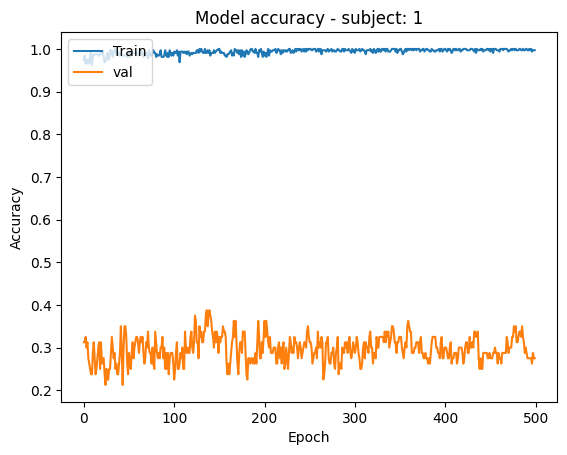

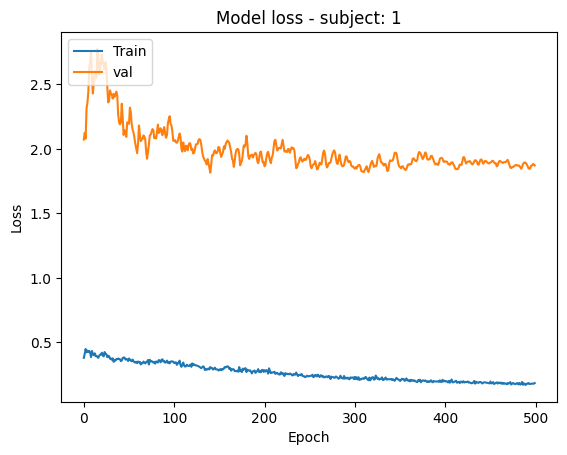


Training on subject  2
Epoch 1/500
6/6 [==============================] - ETA: 0s - loss: 2.4302 - accuracy: 0.2147

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 18s 420ms/step - loss: 2.4302 - accuracy: 0.2147 - val_loss: 2.3813 - val_accuracy: 0.1463 - lr: 0.0010
Epoch 2/500
6/6 [==============================] - 1s 95ms/step - loss: 1.7204 - accuracy: 0.3405 - val_loss: 2.2823 - val_accuracy: 0.1829 - lr: 0.0010
Epoch 3/500
6/6 [==============================] - 1s 95ms/step - loss: 1.6081 - accuracy: 0.4018 - val_loss: 2.2636 - val_accuracy: 0.1829 - lr: 0.0010
Epoch 4/500
6/6 [==============================] - 0s 50ms/step - loss: 1.5634 - accuracy: 0.4202 - val_loss: 2.2732 - val_accuracy: 0.1585 - lr: 0.0010
Epoch 5/500
6/6 [==============================] - 1s 93ms/step - loss: 1.5062 - accuracy: 0.4908 - val_loss: 2.1971 - val_accuracy: 0.1585 - lr: 0.0010
Epoch 6/500
6/6 [==============================] - 1s 94ms/step - loss: 1.4920 - accuracy: 0.5215 - val_loss: 2.1832 - val_accuracy: 0.1463 - lr: 0.0010
Epoch 7/500
6/6 [==============================] - 0s 47ms/step - loss: 1.4585 - accuracy: 0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 17s 276ms/step - loss: 1.4823 - accuracy: 0.5031 - val_loss: 2.4619 - val_accuracy: 0.2073 - lr: 0.0010
Epoch 2/500
6/6 [==============================] - 0s 68ms/step - loss: 1.4127 - accuracy: 0.5215 - val_loss: 2.4818 - val_accuracy: 0.2073 - lr: 0.0010
Epoch 3/500
6/6 [==============================] - 0s 74ms/step - loss: 1.3446 - accuracy: 0.5828 - val_loss: 2.5644 - val_accuracy: 0.3171 - lr: 0.0010
Epoch 4/500
6/6 [==============================] - 0s 63ms/step - loss: 1.2910 - accuracy: 0.5951 - val_loss: 2.5031 - val_accuracy: 0.2439 - lr: 0.0010
Epoch 5/500
6/6 [==============================] - 0s 64ms/step - loss: 1.2798 - accuracy: 0.6319 - val_loss: 2.8474 - val_accuracy: 0.1951 - lr: 0.0010
Epoch 6/500
6/6 [==============================] - 0s 71ms/step - loss: 1.2751 - accuracy: 0.6166 - val_loss: 2.7744 - val_accuracy: 0.1707 - lr: 0.0010
Epoch 7/500
6/6 [==============================] - 0s 78ms/step - loss: 1.2399 - accuracy: 0

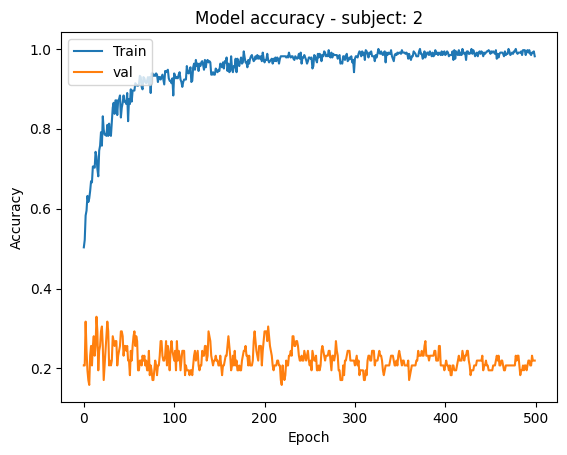

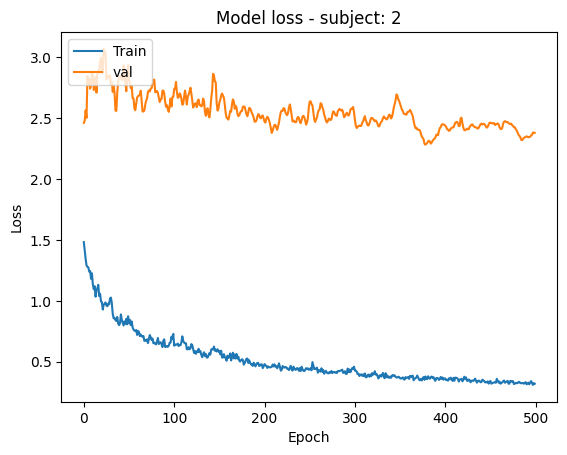


---------------------------------
Validation performance (acc %):
---------------------------------
         sub_1   sub_2     average
         -----   -----     -------
Seed 1:  28.75   14.63     21.69   
Seed 2:  37.50   26.83     32.16   
---------------------------------
Average acc - all seeds: 26.93 %

Train Time  - all seeds: 12.8 min
---------------------------------



In [ ]:
# Train the model
train(model, X_train_arr, y_train_onehot_arr, dataset_conf, train_conf, results_path)

The evaluation loop!

4/4 [==============================] - 0s 8ms/step

---------------------------------
Test performance (acc & k-score):
---------------------------------
                  sub_1   sub_2     average
                  -----   -----     -------
Seed 1: (acc %)   43.56   33.33     38.45   
        (k-sco)   0.294   0.165     0.230   
Seed 2: (acc %)   45.54   32.35     38.95   
        (k-sco)   0.319   0.156     0.238   
----------------------------------
Average - all seeds (acc %): 38.70
                    (k-sco): 0.234

Inference time: 0.99 ms per trial
----------------------------------



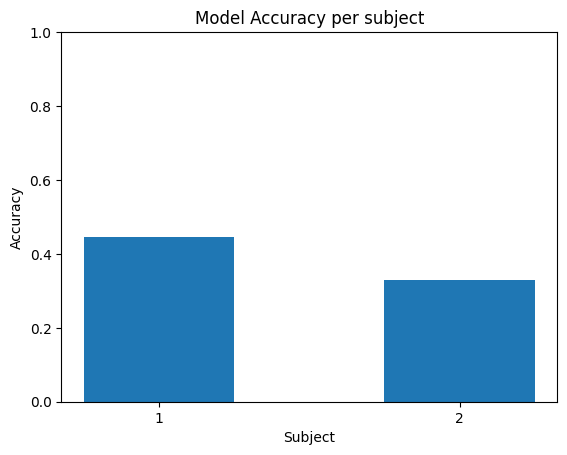

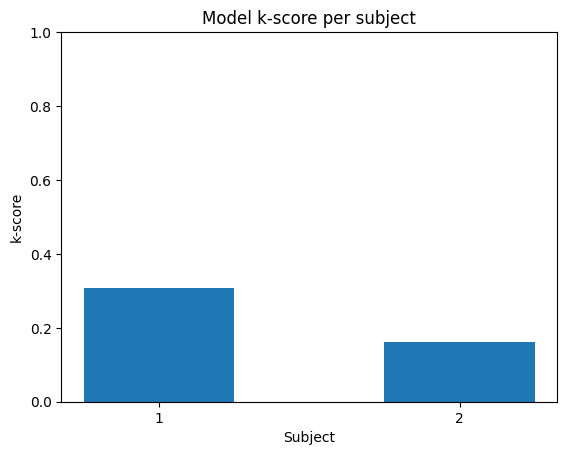

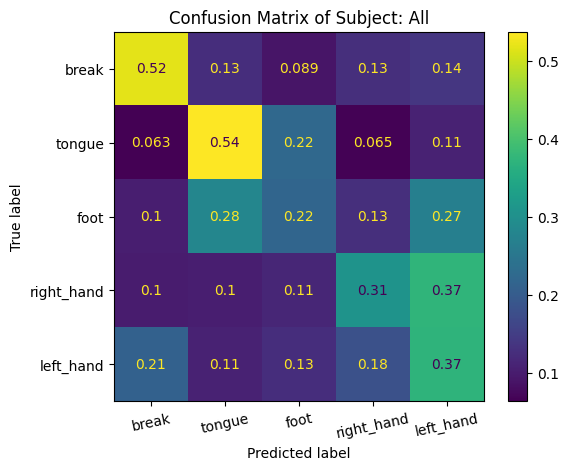

In [ ]:
# Evaluate the model based on the weights saved in the '/results' folder
model = getModel(train_conf.get('model'), dataset_conf)
acc = test(model,X_test_arr, y_test_onehot_arr, dataset_conf, results_path)

Those section used to zip the results folder and download it.
Useful if you use cloud services to run your training.

In [ ]:
!zip -qr ./results.zip ./results


In [ ]:
from google.colab import files
files.download('./results.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

the function below used to quantize the model and save it in tfLite format, that is useful for realtime applications.

The result of that function will be:


```
root: model_{time_stamp}
│
├── test_data
│   ├── X_test_arr.npy
│   └── y_test_onehot_arr.npy
│
└── model_data
    ├── model_file.tf
    └── model_info.json
```




In [ ]:
def save_lite_model(models_dir):

  from datetime import datetime
  import json
  from keras.models import load_model

  now = datetime.now() # current date and time
  timestamp = now.strftime("%m_%d_%H_%M")
  print('Time stamp: ',timestamp)
  # Save the model.
  !mkdir models_lite_{timestamp}
  !mkdir ./models_lite_{timestamp}/test_data
  # Save test sets to evaluate the model results after quantization
  np.save(f'./models_lite_{timestamp}/test_data/X_test_arr.npy', X_test_arr)
  np.save(f'./models_lite_{timestamp}/test_data/y_test_onehot_arr.npy', y_test_onehot_arr)

  #loop to convert every model in the directory
  for file in os.listdir(models_dir):
    if file.endswith('.h5'):
      file_name = file[:-3]
      sub = int(file[-4])-1
      run = int(models_dir[-2])-1
      model_path = models_dir + file
      print(model_path)
      model = load_model(model_path)

      converter = tf.lite.TFLiteConverter.from_keras_model(model)
      converter.post_training_quantize = True
      converter.optimizations = [tf.lite.Optimize.DEFAULT]
      tflite_model = converter.convert()

      !mkdir ./models_lite_{timestamp}/model_lite_{file_name}

      with open(f'./models_lite_{timestamp}/model_lite_{file_name}/model__{file_name}_{timestamp}.tflite', 'wb') as file:
        file.write(tflite_model)
      file.close()

      #we create json file that contain all needed info about each model.
      info = {
          'accuracy': acc[sub,run],
          'classes' : classes_labels,
          'n_samples': in_samples,
          'n_channels': n_channels,
          'subject': file_name,
      }

      json_data = json.dumps(info)
      with open(f'./models_lite_{timestamp}/model_lite_{file_name}/model_info_{file_name}_{timestamp}.json', 'w') as file:
        file.write(json_data)
      file.close()

  #zip folder contain tflite models and thier test dataset then download
  !zip -qr ./models_lite_{timestamp}.zip ./models_lite_{timestamp}/*
  # files.download(f'./models_lite_{timestamp}.zip')

Run tfLite model conversion!

In [ ]:
directory = './results/saved models/run-2/'
save_lite_model(directory)